## main.py

Import all necessary modules

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from keras import models
from keras import layers
from keras import backend as K
from keras.utils import to_categorical
from keras.preprocessing import image
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold

sys.path.insert(0, os.path.abspath('./utils/'))
import util as utils
%matplotlib inline

Using TensorFlow backend.
/opt/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# Some memory clean-up
K.clear_session()

Define a function to create and compile the neural network model (Reusability)

In [3]:
def get_model():
    model = models.Sequential()
    
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)))
    model.add(layers.MaxPool2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPool2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPool2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPool2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPool2D((2, 2)))
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(9, activation='softmax'))
    
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy', 
                  metrics=['acc'])
    
    return model

Store relevant directory paths for future reference

In [4]:
dataset_dir = os.path.abspath('./dataset/')

train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

Store the names (without extension) of all files in the three folders

In [5]:
train_files = [ os.path.splitext(file)[0] for file in os.listdir(train_dir) ]
test_files = [ os.path.splitext(file)[0] for file in os.listdir(test_dir) ]

Store trainLabels.csv (containing the label for each file in the dataset) into a dictionary

In [6]:
data_labels = { filename: label for filename, label in pd.read_csv('./trainLabels.csv').get_values() }

From `data_labels`, map `train_file` and `test_files` to their respective labels and store them into `train_labels` and `test_labels` respectively

In [7]:
train_labels = [ data_labels.get(filename, filename) for filename in train_files ]
test_labels = [ data_labels.get(filename, filename) for filename in test_files ]

With labels stored in their variables, next load the dataset as numpy arrays

In [8]:
train_set = [ utils.load_image_as_np(os.path.join(train_dir, (filename+'.png'))) for filename in train_files ]
test_set = [ utils.load_image_as_np(os.path.join(test_dir, (filename+'.png'))) for filename in test_files ]

#### Preprocessing of labels
The training labels range from 1 - 9 by default.<br/>
Change this to a range of 0 - 8 instead.<br/>
This is to ensure that the results of one-hot encoding of the labels do not contain an extra column full of '0's.

In [9]:
train_labels = [ (i - 1) for i in train_labels ]
test_labels = [ (i - 1) for i in test_labels ]

And now, perform one-hot encoding of the labels with the help of the keras utility function, `to_categorical`

In [10]:
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

#### Preprocessing of data
`train_set` and `test_set` are two lists containing numpy arrays representing images from the respective data images<br/>
Neural network implemented in Keras generally expect numpy arrays as input data, NOT lists.
Hence, the first step is to convert the lists to numpy arrays using `np.asarray`

In [11]:
train_set = np.asarray(train_set)
test_set = np.asarray(test_set)

Next, divide each byte (which represents the grayscale value of each pixel in an image) by 255 to bring all the values to a range of 0 to 1. This does good to the model (Manipulating smaller numbers is better than manipulating larger ones)

In [12]:
train_set = train_set.astype('float32') / 255
test_set = test_set.astype('float32') / 255

In [13]:
print('train_set.shape:       ', train_set.shape)
print('test_set.shape:        ', test_set.shape)

train_set.shape:        (7610, 128, 128, 1)
test_set.shape:         (3258, 128, 128, 1)


In [14]:
k = 4
num_val_samples = len(train_set) // k
num_epochs = 20
all_histories = []

In [15]:
for i in range(k):
    print('Processing fold #', i)
    val_set = train_set[i * num_val_samples: (i + 1) * num_val_samples]
    val_labels = train_labels[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_set = np.concatenate(
        [train_set[:i * num_val_samples], 
         train_set[(i + 1) * num_val_samples:]],
        axis=0)
    
    partial_train_labels = np.concatenate(
        [train_labels[:i * num_val_samples],
         train_labels[(i + 1) * num_val_samples:]],
        axis=0)
    
    sm = SMOTE()
    train_set_res, train_labels_res = sm.fit_resample(partial_train_set.reshape(partial_train_set.shape[0], (128 * 128 * 1)), partial_train_labels)
    train_set_res = train_set_res.reshape((train_set_res.shape[0], 128, 128, 1))
    print(train_set_res.shape)
    print(train_labels_res.shape)
    
    model = get_model()
    history = model.fit(train_set_res, train_labels_res, 
                       batch_size=512, epochs=num_epochs, 
                       validation_data=(val_set, val_labels) , verbose=0)  #  # verbose=0 is used to train the model in silent mode
    all_histories.append(history)
    print('Processed fold #', i)
    print('\n')

Processing fold # 0
(14562, 128, 128, 1)
(14562, 9)
Processed fold # 0


Processing fold # 1
(14292, 128, 128, 1)
(14292, 9)
Processed fold # 1


Processing fold # 2
(14166, 128, 128, 1)
(14166, 9)
Processed fold # 2


Processing fold # 3
(14175, 128, 128, 1)
(14175, 9)
Processed fold # 3




In [16]:
len(all_histories[0].history['acc'])

20

In [17]:
all_accuracies = [ history.history['acc'] for history in all_histories ]
all_val_accuracies = [ history.history['val_acc'] for history in all_histories ]
all_losses = [ history.history['loss'] for history in all_histories ]
all_val_losses = [ history.history['val_loss'] for history in all_histories ]

In [18]:
average_acc_history = [
    np.mean([accs[i] for accs in all_accuracies]) for i in range(num_epochs)
]

In [19]:
average_val_acc_history = [
    np.mean([val_accs[i] for val_accs in all_val_accuracies]) for i in range(num_epochs)
]
average_loss_history = [
    np.mean([loss[i] for loss in all_losses]) for i in range(num_epochs)
]
average_val_loss_history = [
    np.mean([val_loss[i] for val_loss in all_val_losses]) for i in range(num_epochs)
]

In [20]:
epochs = range(1, len(average_acc_history) + 1)

<Figure size 432x288 with 0 Axes>

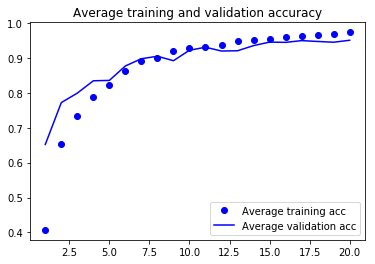

<Figure size 432x288 with 0 Axes>

In [21]:
plt.plot(epochs, average_acc_history, 'bo', label='Average training acc')
plt.plot(epochs, average_val_acc_history, 'b', label='Average validation acc')
plt.title('Average training and validation accuracy')
plt.legend()

plt.figure()

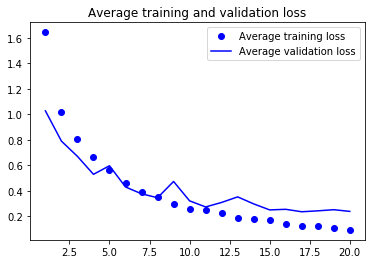

In [22]:
plt.plot(epochs, average_loss_history, 'bo', label='Average training loss')
plt.plot(epochs, average_val_loss_history, 'b', label='Average validation loss')
plt.title('Average training and validation loss')
plt.legend()

plt.show()

In [29]:
sm = SMOTE()
train_set_res, train_labels_res = sm.fit_resample(train_set.reshape(train_set.shape[0], (128 * 128 * 1)), train_labels)

In [31]:
train_set_res = train_set_res.reshape((train_set_res.shape[0], 128, 128, 1))

In [32]:
model = get_model()
model.fit(train_set_res, train_labels_res, epochs=10, batch_size=512)

Epoch 1/10
19062/19062 [==============================] - 8s - loss: 1.4547 - acc: 0.4857     
Epoch 2/10
19062/19062 [==============================] - 8s - loss: 0.8727 - acc: 0.7088     
Epoch 3/10
19062/19062 [==============================] - 8s - loss: 0.7020 - acc: 0.7701     
Epoch 4/10
19062/19062 [==============================] - 8s - loss: 0.5940 - acc: 0.8090     
Epoch 5/10
19062/19062 [==============================] - 8s - loss: 0.4706 - acc: 0.8568     
Epoch 6/10
19062/19062 [==============================] - 8s - loss: 0.3765 - acc: 0.8954     
Epoch 7/10
19062/19062 [==============================] - 8s - loss: 0.3434 - acc: 0.9042     
Epoch 8/10
19062/19062 [==============================] - 8s - loss: 0.2797 - acc: 0.9249     
Epoch 9/10
19062/19062 [==============================] - 8s - loss: 0.2451 - acc: 0.9332     
Epoch 10/10
19062/19062 [==============================] - 8s - loss: 0.2073 - acc: 0.9447     


In [36]:
predicted_labels = model.predict_classes(test_set, batch_size=128)

3200/3258 [============================>.] - ETA: 0s

In [37]:
predicted_labels

array([1, 8, 0, ..., 1, 6, 5])

In [39]:
test_labels_original = np.argmax(test_labels, axis=1)

In [42]:
confusion_matrix(test_labels_original, predicted_labels)

array([[396,   5,   1,   0,   6,   7,   2,  22,   2],
       [  4, 737,   0,   0,   1,   7,   0,  11,   5],
       [  0,   0, 823,   0,   0,   0,   0,   0,   1],
       [  7,   1,   0, 118,  21,  14,   4,   3,  16],
       [  0,   0,   0,   0,   5,   0,   0,   3,   0],
       [ 11,   5,   0,   0,   3, 196,   3,   2,   7],
       [  0,   0,   0,   0,   0,   1, 137,   0,   4],
       [ 22,   2,   5,   2,   7,   9,   1, 332,   5],
       [  2,   3,   0,   0,   0,  22,   0,   0, 255]])

In [43]:
y_true = pd.Series(test_labels_original)
y_pred = pd.Series(predicted_labels)

pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,2,3,4,5,6,7,8,All
True,,,,,,,,,,
0,396,5,1,0,6,7,2,22,2,441
1,4,737,0,0,1,7,0,11,5,765
2,0,0,823,0,0,0,0,0,1,824
3,7,1,0,118,21,14,4,3,16,184
4,0,0,0,0,5,0,0,3,0,8
5,11,5,0,0,3,196,3,2,7,227
6,0,0,0,0,0,1,137,0,4,142
7,22,2,5,2,7,9,1,332,5,385
8,2,3,0,0,0,22,0,0,255,282


In [52]:
model.evaluate?

In [53]:
results = model.evaluate(test_set, test_labels)

3168/3258 [============================>.] - ETA: 0s

In [54]:
results

[0.29916255883163584, 0.9205033761215327]